In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Fundamental classes
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os

# Image related
import cv2
from PIL import Image

# For ploting
import matplotlib.pyplot as plt

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [9]:
# Setting variables for later use
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join('/content/drive/MyDrive/Datasets/','Train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

In [10]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(10796, 30, 30, 3) (10796,)
(8636, 30, 30, 3) (2160, 30, 30, 3) (8636,) (2160,)


In [11]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Model display
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

In [12]:
# Training the Model
with tf.device('/GPU:0'):
    epochs = 15
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15
270/270 [==============================] - 39s 142ms/step - loss: 1.0621 - accuracy: 0.7495 - val_loss: 0.1666 - val_accuracy: 0.9574
Epoch 2/15
270/270 [==============================] - 37s 137ms/step - loss: 0.2966 - accuracy: 0.9189 - val_loss: 0.1345 - val_accuracy: 0.9713
Epoch 3/15
270/270 [==============================] - 39s 146ms/step - loss: 0.2156 - accuracy: 0.9428 - val_loss: 0.1095 - val_accuracy: 0.9755
Epoch 4/15
270/270 [==============================] - 37s 139ms/step - loss: 0.1553 - accuracy: 0.9588 - val_loss: 0.0609 - val_accuracy: 0.9847
Epoch 5/15
270/270 [==============================] - 46s 171ms/step - loss: 0.1534 - accuracy: 0.9561 - val_loss: 0.0891 - val_accuracy: 0.9778
Epoch 6/15
270/270 [==============================] - 40s 147ms/step - loss: 0.1354 - accuracy: 0.9601 - val_loss: 0.0623 - val_accuracy: 0.9852
Epoch 7/15
270/270 [==============================] - 39s 142ms/step - loss: 0.1238 - accuracy: 0.9648 - val_loss: 0.0285 - val_ac

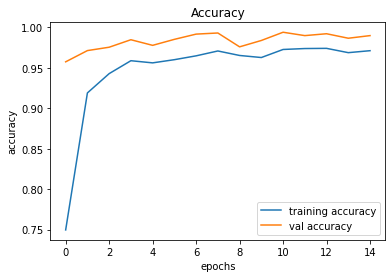

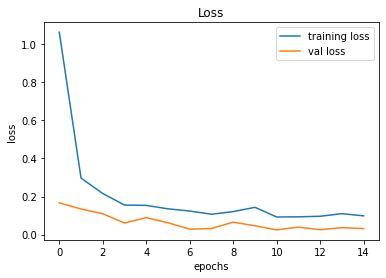

In [13]:
# Plotting performance graphs
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
# testing accuracy on test dataset
from sklearn.metrics import accuracy_score

# Importing the test dataset
y_test = pd.read_csv('/content/drive/MyDrive/Datasets/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/drive/MyDrive/Datasets/'+img)
        image = image.resize([30, 30])
        data.append(np.array(image))

X_test=np.array(data)

with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))


0.26991290577988913


In [16]:
# Saving the Model 
model.save('traffic_classifier.h5')